# APERO Demos

The aim of these demos is to walk you through some of the key steps in the
data reduction using APERO.

## Prerequisites for exercises

- Python 3.9  (e.g. via [conda](https://docs.conda.io/en/latest/miniconda.html))
    ```
    conda create --name=apero-demo python=3.9
    conda activate apero-demo
    pip install -r requirements.txt
    ```


- DS9 ([download](https://sites.google.com/cfa.harvard.edu/saoimageds9))


- dfits and fitsort
  - python implementation: [download](https://astrom-tom.github.io/dfitspy/build/html/installation.html)
  - C implmentation: [download](https://github.com/granttremblay/eso_fits_tools)


- Download the file bundle: [download](https://www.astro.umontreal.ca/~artigau/apero_demo/apero_nirps_demo.tar)


## Exercise 5: Telluric correction

- Step 1: Find the extracted s1d for Proxima (fiber A)
- Step 2: Find the telluric corrected s1d for Proxima (fiber A)
- Step 3: Find the associated recon and s1d template
- Step 4: Shift the s1d template using the BERV
- Step 5: Plot the flux (corrected/uncorrected) and template
- Step 6: Plot the normalized ratio of the corrected flux to template
- Step 7: Plot the transmission
- Bonus: Plot the OH line model from the pclean file (use fitsinfo to look at the extension names)

In [19]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from astropy import constants
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline as IUSpline

In [20]:
# notebook only
%matplotlib inline

In [21]:
def doppler(wavemap, velocity):
    """
    Shift a wave grid by a velocity

    :param wavemap: np.array the wavelength solution to shift
    :param velocity: float, the velocity to shift by in m/s

    :return: np.array, the shifted wavemap
    """
    # calculate v/c
    vc = velocity / constants.c.value
    # calculate the wavelength shift
    shift = np.sqrt((1 - vc) / (1 + vc))
    # shift the wave map
    return wavemap * shift

In [22]:
# relevant files
file_sp = 'NIRPS_2023-01-20T08_42_08_941_pp_s1d_v_tcorr_A.fits'
file_template = 'Template_s1dv_PROXIMA_sc1d_v_file_A.fits'
file_recon = 'NIRPS_2023-01-20T08_42_08_941_pp_s1d_v_recon_A.fits'


In [23]:
# read the science spectrum
sp = Table.read(file_sp, hdu=1)
# avoid masking that messes some operations. Replace with NaNs
sp['flux'] = np.array(sp['flux'])
header = fits.getheader(file_sp)

# read template for Proxima
template = Table.read(file_template, hdu=1)
template['flux'] = np.array(template['flux'])

# read reconstructed absorption to know abso at given residual position
recon = Table.read(file_recon, hdu=1)
recon['flux'] = np.array(recon['flux'])

In [24]:
# construct a spline to Doppler-shift the template
# valid points in template
valid = np.isfinite(template['flux'])
x = np.array(template['wavelength'][valid])
y = np.array(template['flux'][valid])
# spline for BERV offset of template
spl = IUSpline(x, y, k=1, ext=1)

In [25]:
# get the berv (in the header in m/s) --> km/s
berv = header['BERV'] * 1000
# update the template with the obsevation's BERV
template['flux'] = spl(doppler(template['wavelength'], -berv))

with warnings.catch_warnings(record=True) as _:
    # ratio observation to teomplate
    ratio = sp['flux'] / template['flux']
    # normalize to a median of 1
    ratio /= np.nanmedian(ratio)

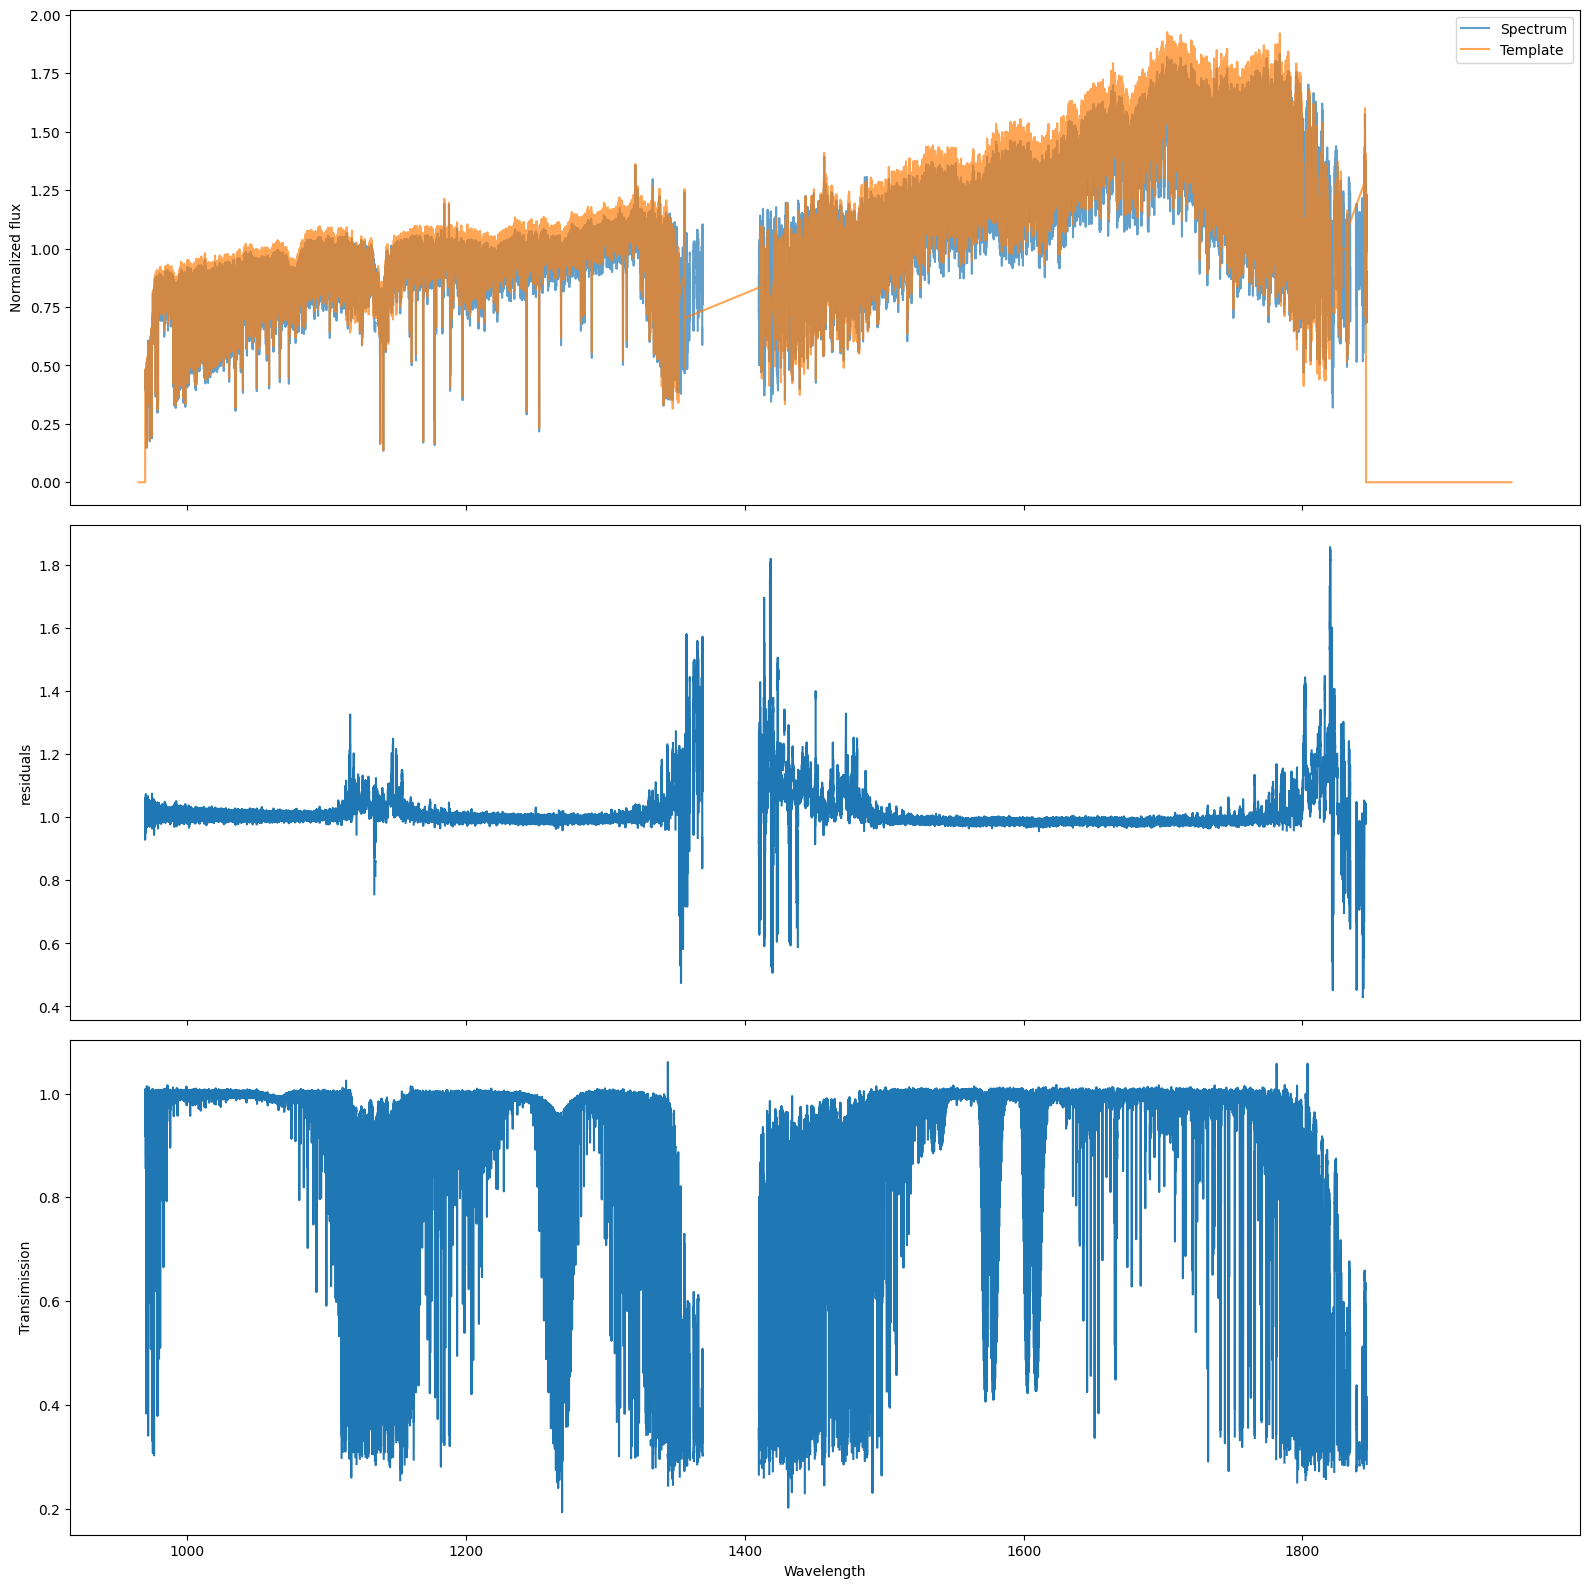

In [26]:
# Fancy plots to show residuals
fig, ax = plt.subplots(nrows=3, ncols=1, sharex='all', figsize=(16,16))
# flux plot
ax[0].plot(sp['wavelength'], sp['flux'] / np.nanmedian(sp['flux']),
           label='Spectrum', alpha=0.7)
ax[0].plot(template['wavelength'],
           template['flux'] / np.nanmedian(template['flux']),
           label='Template', alpha=0.7)
# ratio of template to science plot
ax[1].plot(template['wavelength'], ratio)
# absorption plot
ax[2].plot(recon['wavelength'], recon['flux'])
ax[2].set(xlabel='Wavelength', ylabel='Transimission')
ax[1].set(ylabel='residuals')
ax[0].set(ylabel='Normalized flux')
ax[0].legend()
plt.tight_layout()
plt.show()